In [177]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from model import Net

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=51200, out_features=4000, bias=True)
  (fc1_bn): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=T

In [179]:
from FacePointsDataset import FacePointsDataset
from FacePointsDataset import Rescale, RandomCrop, Normalize, ToTensor


data_transform = transforms.Compose([Rescale(256),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])



transformed_dataset = FacePointsDataset(csv_file='data/train-test-data/training_frames_keypoints.csv',
                                             root_dir='data/train-test-data/training/',
                                             transform=data_transform)



# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [180]:
batch_size = 10
train_loader = DataLoader(transformed_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)

In [181]:
test_dataset = FacePointsDataset(csv_file='data/train-test-data/test_frames_keypoints.csv',
                                             root_dir='data/train-test-data/test/',
                                             transform=data_transform)

In [182]:
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [183]:
def net_sample_output():
    
    for i, sample in enumerate(test_loader):
        
        images = sample['image']
        key_pts = sample['keypoints']

        images = Variable(images)
        images = images.type(torch.FloatTensor)

        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        if i == 0:
            return images, output_pts, key_pts

In [184]:
test_images, test_outputs, gt_pts = net_sample_output()

RuntimeError: Given groups=1, weight[512, 128, 3, 3], so expected input[10, 256, 12, 12] to have 128 channels, but got 256 channels instead

In [26]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [41]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        image = test_images[i].data
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))

        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call i


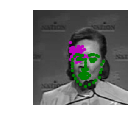

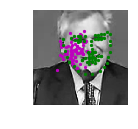

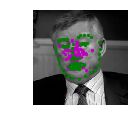

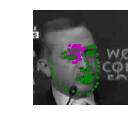

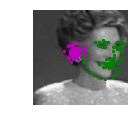

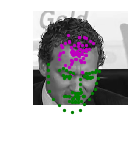

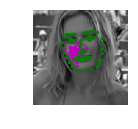

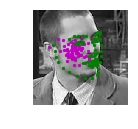

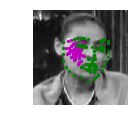

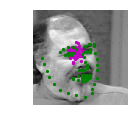

In [39]:
visualize_output(test_images, test_outputs, gt_pts)

In [147]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [148]:
def train_net(n_epochs):
    net.train()

    for epoch in range(n_epochs):
        
        running_loss = 0.0

        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()

            running_loss += loss.data[0]
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [149]:
n_epochs = 3
train_net(n_epochs)

tensor([[[[  0.3728,   0.3320,   0.2072,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.3405,   0.3125,   0.2095,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.3384,   0.3065,   0.2166,  ...,   0.0000,   0.0000,
             0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,
             0.0000]],

         [[  0.6096,   0.5565,   0.4184,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.5821,   0.5315,   0.4125,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.5413,   0.4937,   0.4130,  ...,   0.0000,   0.0000,
             0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,
           

RuntimeError: size mismatch, m1: [14 x 36864], m2: [51200 x 4000] at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/TH/generic/THTensorMath.c:2033

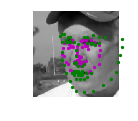

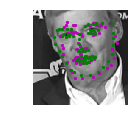

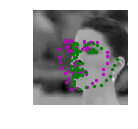

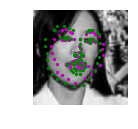

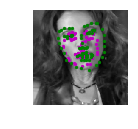

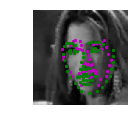

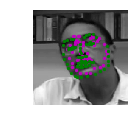

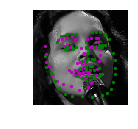

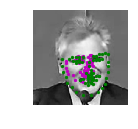

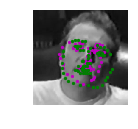

In [49]:
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

In [215]:
model_dir = 'savedModels/'
model_name = 'TrainedFRModel.pt'

torch.save(net.state_dict(), model_dir+model_name)

[[ 0.24028835  0.30132696  0.2487472 ]
 [-0.05700131 -0.34444907 -0.21875529]
 [-0.07139881  0.08709051 -0.2469965 ]]
(3, 3)


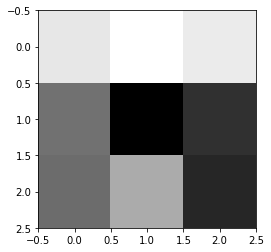

In [217]:
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

plt.imshow(w[filter_index][0], cmap='gray')

torch.Size([1, 224, 224])


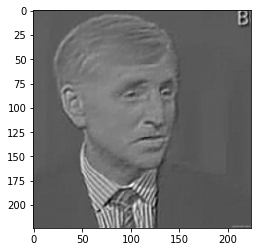

In [220]:
import cv2

kernel = w[4][0]
data = next(iter(test_loader))
print(data['image'][0].shape)
image = data['image'][0] 
image = image.numpy()
image = np.transpose(image, (1, 2, 0)) 

image = cv2.filter2D(image, -1, kernel)
plt.imshow(np.squeeze(image), cmap='gray')